In [101]:
import kornia
import json
import torch
import kornia.augmentation as K
from kornia.constants import DataKey
from kornia.augmentation.container import AugmentationSequential, ManyToOneAugmentationDispather, VideoSequential
from einops import rearrange
from PIL import Image, ImageDraw
torch.set_printoptions(precision=3, profile='short', sci_mode=False, linewidth=1000)

import numpy as np
from decord import VideoReader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from IPython.display import Image as IPImage

def tensors_to_pillow(tensors):
    assert tensors.dim() == 4
    images = []
    for tensor in tensors:
        image = TF.to_pil_image(tensor)
        images.append(image)
    return images

def save_pillow_images(images, path='/tmp/test.gif'):
    images[0].save(path, save_all=True, append_images=images[1:], duration=100, loop=0)

def draw_box(image, box, color='red'):
    draw = ImageDraw.Draw(image)
    w, h = image.size
    x1, y1, x2, y2 = box.tolist()
    x1, y1, x2, y2 = int(x1 * w), int(y1 * h), int(x2 * w), int(y2 * h)
    draw.rectangle([x1, y1, x2, y2], outline=color, width=5)
    return image

def draw_rt(images, rt: list[dict], color='red'):
    new_images = []
    for image, box in zip(images, rt):
        new_image = draw_box(image, box, color)
        new_images.append(new_image)
    return new_images

def viz_tensors(tensors):
    p_tmp = '/tmp/img.gif'
    save_pillow_images(tensors_to_pillow(tensors), p_tmp)
    return IPImage(filename=p_tmp)

def viz_rt(tensors, rt: list[dict], color='red'):
    p_tmp = '/tmp/rt.gif'
    save_pillow_images(draw_rt(tensors_to_pillow(tensors), rt, color), p_tmp)
    return IPImage(filename=p_tmp)


def get_sample():
    for ann in json.load(open('/data/gunsbrother/repos/vq2d-lightning/data/vq_v2_train_anno.json')):
        if len(rt:=ann['response_track']) > 9:
            clip_uid = ann['clip_uid']
            ow, oh = ann['original_width'], ann['original_height']
            display(rt)
            print(ann['object_title'])
            print(ow, oh)
            fnos = [res['fno'] for res in rt]
            bboxes = [{'x': res['x']/ow, 'y': res['y']/oh, 'w': res['w']/ow, 'h': res['h']/oh} for res in rt]
            bboxes = torch.tensor([[box['x'], box['y'], box['x'] + box['w'], box['y'] + box['h']] for box in bboxes])
            yield clip_uid, fnos, bboxes

gen = get_sample()


In [102]:
clip_uid, fnos, bboxes = next(gen)
print(clip_uid)
bboxes.shape

[{'fno': 1099, 'x': 929.68, 'y': 540.42, 'w': 11.2, 'h': 41.4},
 {'fno': 1100, 'x': 917.51, 'y': 542.37, 'w': 12.18, 'h': 43.34},
 {'fno': 1101, 'x': 910.69, 'y': 546.26, 'w': 12.18, 'h': 48.12},
 {'fno': 1102, 'x': 930.17, 'y': 544.32, 'w': 18.51, 'h': 51.9},
 {'fno': 1103, 'x': 966.7, 'y': 547.33, 'w': 17.23, 'h': 56.89},
 {'fno': 1104, 'x': 1004.2, 'y': 557.32, 'w': 21.08, 'h': 62.97},
 {'fno': 1105, 'x': 1032.44, 'y': 549.99, 'w': 24.4, 'h': 74.68},
 {'fno': 1106, 'x': 1066.68, 'y': 542.66, 'w': 34.13, 'h': 87.75},
 {'fno': 1107, 'x': 1123.92, 'y': 554.75, 'w': 40.58, 'h': 103.47},
 {'fno': 1108, 'x': 1222.56, 'y': 568.19, 'w': 52.98, 'h': 118.77},
 {'fno': 1109, 'x': 1352.76, 'y': 591.14, 'w': 76.09, 'h': 141.48}]

mr krips
1440 1080
3fe39989-54ed-4a3a-bea4-88be05ff8df7


torch.Size([11, 4])

torch.Size([11, 3, 448, 597])


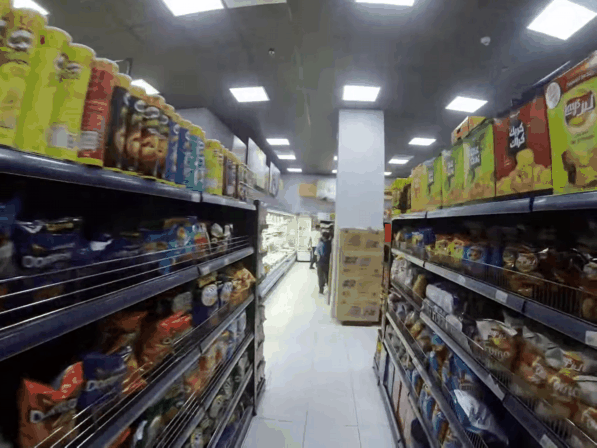

In [90]:
vr = VideoReader(f'/data/datasets/ego4d_data/v2/clips/{clip_uid}.mp4')
frames = vr.get_batch(6*np.array(fnos)).asnumpy()
frames = torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.
_, _, H, W = frames.shape
H, W = 448, int(W/H*448)
frames = F.interpolate(frames, (H, W), mode='bilinear', align_corners=True, antialias=True)
print(frames.shape)

# Example visualization
display(viz_rt(frames, bboxes))

In [91]:
input = torch.randn(2, 3, 5, 6)
mask = torch.ones(2, 3, 5, 6)
aug_list = ManyToOneAugmentationDispather(
    AugmentationSequential(
        kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
        kornia.augmentation.RandomAffine(360, p=1.0),
        data_keys=["input", "mask",],
    ),
    AugmentationSequential(
        kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
        kornia.augmentation.RandomAffine(90, p=1.0),
        data_keys=["input", "mask",],
    )
)
output = aug_list(input, mask)
input.shape, output[0][0].shape

(torch.Size([2, 3, 5, 6]), torch.Size([2, 3, 5, 6]))

torch.Size([1, 11, 3, 448, 597])


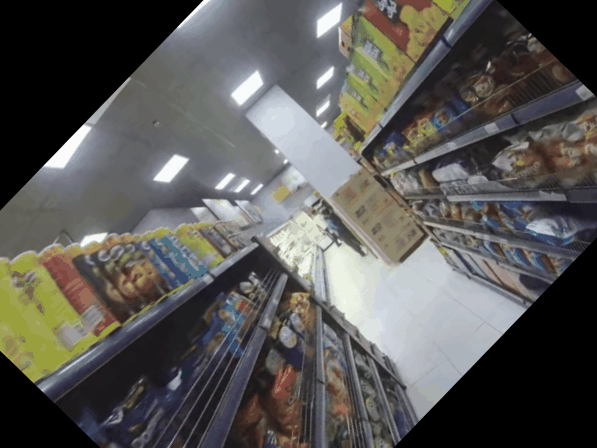

In [93]:
aug_list = VideoSequential(
    kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, hue=0., p=1.0),
    kornia.augmentation.RandomAffine(360, p=1.0),
    # random_apply=10,
    data_format="BTCHW",
    same_on_frame=True
)

output = aug_list(frames[None])
print(output.shape)
viz_tensors(output[0])

# 커스텀

torch.Size([1, 11, 3, 224, 224])


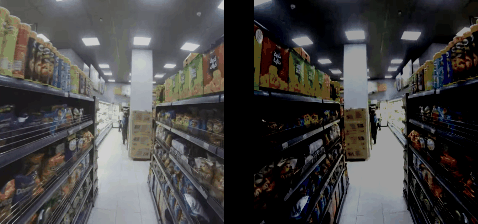

In [94]:
args = (
    kornia.augmentation.ColorJiggle(brightness=0.4, contrast=0.4, saturation=0.3, hue=0, p=1.0),
    kornia.augmentation.RandomHorizontalFlip(p=0.5),
    kornia.augmentation.RandomResizedCrop(
        (224, 224),  # resize size after crop
        scale=(0.66, 1.0),  # crop size as a ratio of the input image
        ratio=(.8, 1.2),  # aspect ratio range
        p=1.0),  # h, w
)
aug_list1 = VideoSequential(*args, data_format="BTCHW", same_on_frame=False)
aug_list2 = VideoSequential(*args, data_format="BTCHW", same_on_frame=True)

output = aug_list1(frames[None])
output2 = aug_list2(frames[None])

print(output.shape)
combined = torch.cat([output[0], torch.zeros(*output.shape[1:-1], 30), output2[0]], dim=-1)
viz_tensors(combined)

In [95]:
bboxes[None, :, None, :].shape

torch.Size([1, 11, 1, 4])

In [103]:
from einops import rearrange
rearrange(bboxes, 't c -> () t () c').shape

torch.Size([1, 11, 1, 4])

torch.Size([1, 11, 3, 448, 448])
torch.Size([11, 4])
{'brightness_factor': tensor([1.079, 1.079, 1.079, 1.079, 1.079, 1.079, 1.079, 1.079, 1.079, 1.079, 1.079]), 'contrast_factor': tensor([0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998, 0.998]), 'hue_factor': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'saturation_factor': tensor([1.074, 1.074, 1.074, 1.074, 1.074, 1.074, 1.074, 1.074, 1.074, 1.074, 1.074]), 'order': tensor([1, 0, 2, 3]), 'batch_prob': tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), 'forward_input_shape': tensor([  1,   3, 448, 597])}


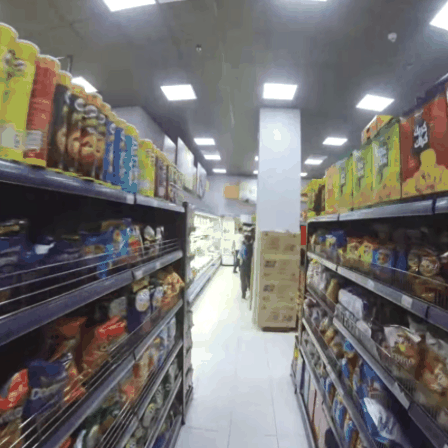

In [154]:
aug_list = AugmentationSequential(
    VideoSequential(
        kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, hue=0., p=1.0),
        # kornia.augmentation.RandomAffine(360, p=1.0),
        kornia.augmentation.RandomResizedCrop((448, 448), scale=(0.66, 1.0), ratio=(.8, 1.2), p=1.0),  # h, w
        data_format="BTCHW", same_on_frame=True
    ),
    data_keys=[DataKey.INPUT, DataKey.KEYPOINTS, DataKey.KEYPOINTS],
)

bboxes_ = rearrange(bboxes * torch.tensor([W, H, W, H]), 't c -> () t () c')
bboxes_ = bboxes_.split(2, dim=-1)
output = aug_list(frames[None], bboxes_[0], bboxes_[1])
bboxes_ = torch.cat([output[1], output[2]], dim=-1).squeeze() / 448
print(output[0].shape)
print(bboxes_.shape)
print(aug_list._params[0].data[0].data)
viz_rt(output[0][0], bboxes_)

In [129]:
bboxes_

tensor([[344.518, 227.760, 348.745, 245.286],
        [339.924, 228.586, 344.521, 246.933],
        [337.350, 230.232, 341.947, 250.603],
        [344.703, 229.411, 351.689, 251.382],
        [358.490, 230.685, 364.993, 254.769],
        [372.644, 234.914, 380.600, 261.572],
        [383.302, 231.811, 392.512, 263.426],
        [396.226, 228.708, 409.107, 265.856],
        [417.830, 233.826, 433.146, 277.629],
        [455.060, 239.516, 475.056, 289.796],
        [504.201, 249.232, 532.920, 309.126]])